<a href="https://colab.research.google.com/github/musicjae/Reinforcement_Learning/blob/master/intro_RL/Atari_Breakdown_with_DQN_and_A3C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving t3.JPG to t3.JPG
User uploaded file "t3.JPG" with length 567098 bytes


In [ ]:
from IPython.display import Image

In [1]:
import matplotlib.pyplot as plt

# 1. Breakout Game with the CNN,DQN
  
아타리? 게임 회사. 2015년에 딥마인드에서 그 중 하나인 브레이크 아웃이란 벽돌 깨기 게임을 강화학습으로 훈련시켜 수행하는 것을 공개.  
  


## 1.1 수행  
  
- Agent 이동: 제자리, 왼쪽, 오른쪽  
- 보상:   
  - 벽돌 깸 --> +  
   > 뒤에 있는 벽돌일수록 높은 보상  
  - 아무것도 깨지 못하는 평소 상태 --> 0  
  - 공을 놓침 --> -1   

## 1.2 CNN  
  
- 게임 화면이 input인 경우 --> input vector 크기 증가 --> 영상인식 분야에서 널리 사용되는 CNN 사용 요구돼

### 1.2.1 Motivation of CNN  
  
###### 사람은 어떻게 시각 정보를 처리하는가?  
- 수용영역 Receptive Field  
- 추상화 Abstraction  
  > 수용영역을 가진 시신경은 전체 시각 input 중 **일부**에만 반응: 추상화  
- 시각 중추 Visual Cortex  
> 이것은 사람 시야의 전체를 쪼개서 여러 가지 조각으로 인식

###### CNN은 어떻게 이미지 정보를 처리하는가?  
- 컨볼루션 필터  
> 컨볼루션 필터는 알고리즘에서 시각 중추 같은 역할을 한다. 이것은 이미지의 Noise를 제거하거나 어떤 Features를 강조할 때 사용된다. // BOX 형태 필터가 popular

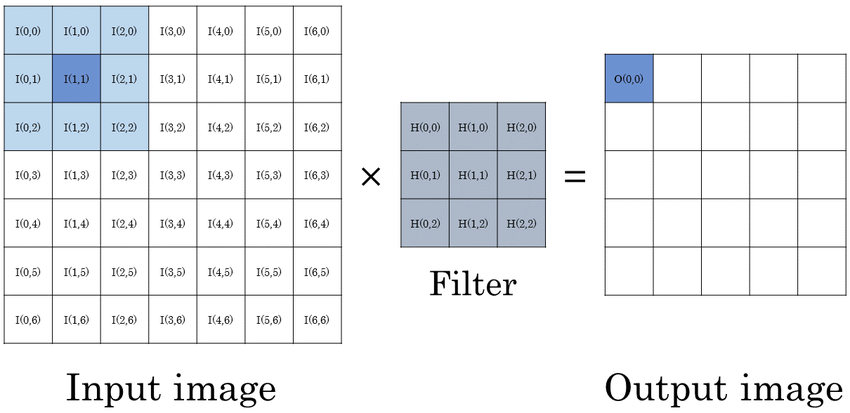

In [ ]:
Image('11.png',width=800)

###### 필터는 어떻게 작동하는가? (주제 외)

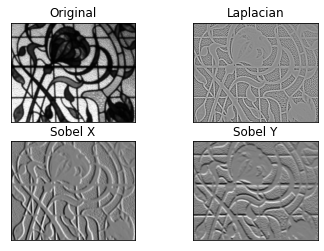

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# loading image
#img0 = cv2.imread('SanFrancisco.jpg',)
img0 = cv2.imread('12.jpg',)

# converting to gray scale
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# remove noise
img = cv2.GaussianBlur(gray,(3,3),0)

# convolute with proper kernels
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

# https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php

위 사례에서 보듯이, 어떤 필터를 사용하는지에 따라 우리는 전혀 다른 정보를 얻을 수 있다. 따라서 실험자는 특정 목적에 맞게 필터를 사용하여 원하는 정보를 추출하는 것이 바람직하다.  
이 "Feature 추출"은 본래 유저가 수행했지만, CNN을 이용하면 사람이 직접하지 않아도 된다. 왜냐하면 CNN을 사용하면 <특징 추출 단계>를 거치지 않고 End-to-End로 학습하기 때문이다.

## 1.3 CNN in the Breakout

- {The number of filters, Size of filters, Stride, Activation} $\in$ Convolution Layer  
- 

In [ ]:
# example 

Conv = Conv2D(32, (8,8),strides=(4,4), activation='relu') # 필터 개수, 사이즈, 보폭stride, 활성화 함수

위 같은 컨볼루션 층을 3 개 쌓기

In [ ]:
Conv1 = Conv2D(32, (8,8),strides=(4,4), activation='relu')
Conv2 = Conv2D(32, (8,8),strides=(4,4), activation='relu')
Conv3 = Conv2D(32, (8,8),strides=(4,4), activation='relu')

위에서 쌓은 층들을 nodes를 일렬로 펼치기 위해 Flattening 하기

In [ ]:
flatten=Flatten()
fc = Dense(512,activation='relu')

이렇게 펼쳐진 nodes는 마지막에 action의 개수 만큼 Q함숫값을 출력한다.  
> 결국 이 과정은 CNN을 통해 Q함수를 근사하는 것이다.

# Applications

## 2.1 전처리  
  
전처리 --> 히스토리 만들기

In [ ]:
def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe

전처리를 하지 않으면 모델은 제대로 학습을 할 수 없다. 왜냐하면 모델은 전처리가 없이 입력된 이미지 하나만으로는 어떤 상황인지 인식하지 못하기 때문이다. 따라서 아래와 같이 "메인 루프" 안에서 하나의 이미지를 4 개로 복사하여 하나의 히스토리를 만들어준다. (지금 어떤 상황인지를 더 잘 인식하기 위해 이전 시점 상황과 나중 시점 상황을 살펴보기 위함)

In [ ]:
state = pre_processing(observe)
history = np.stack((state, state, state, state), axis=2) # state가 [84,84,1]의 형태를 갖으니, 그 1에 해당하는 축에 대해 axis를 쌓아줘야 해서, axis=2
history = np.reshape([history], (1, 84, 84, 4))

한 루프를 지날 때 마다, envs는 에이전트에게 새로운 observe를 제공해야 한다. 즉 오래된 state는 버리고 새로운 state를 제공한다.

In [ ]:
next_state = pre_processing(observe)
next_state = np.reshape([next_state], (1, 84, 84, 1))
next_history = np.append(next_state, history[:, :, :, :3], axis=3)

## 2.2 모델 만들기  
  
- 타깃 모델, 트레이닝 모델 만들기  
- optimizer

In [ ]:
# 모델과 타겟모델을 생성하고 타겟모델 초기화
self.model = self.build_model()
self.target_model = self.build_model()
self.update_target_model()
self.optimizer = self.optimizer()

## 2.3 행동 선택  
  
만들어진 이 모델은 행동을 선택할 수 있다. 이것은 model()을 이용해 출력한 **Q함수를_통해_선택**한다. 여기서 에이전트는 **$\epsilon$-탐욕정책을**통해 행동을 선택한다.

In [ ]:
# 입실론 탐욕 정책으로 행동 선택
    def get_action(self, history):
        history = np.float32(history / 255.0) # 픽셀 값을 0 - 255가 아닌 0 - 1 사이 값이 되도록 해준다.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(history)
            return np.argmax(q_value[0])

## 2.4 환경이 에이전트에게 정보 제공  


In [ ]:
# 선택한 행동으로 환경에서 한 타임스텝 진행
observe, reward, done, info = env.step(real_action)

## 2.5 정보를 리플레이에 저장  
  
한 스텝 진행 후, 환경에서 얻은 정보를 샘플로서 리플레이에 저장

In [ ]:
# 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
def append_sample(self, history, action, reward, next_history, dead):
    self.memory.append((history, action, reward, next_history, dead))

## 2.6 리플레이 메모리를 이용하여 학습 진행  
  
- 50000 스텝 이후부터 학습 (memory < 50000 $\to$ 학습 x)

In [ ]:
def train_model(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_step

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch = random.sample(self.memory, self.batch_size)

        history = np.array([sample[0][0] / 255. for sample in batch],
                           dtype=np.float32)
        actions = np.array([sample[1] for sample in batch])
        rewards = np.array([sample[2] for sample in batch])
        next_history = np.array([sample[3][0] / 255. for sample in batch],
                                dtype=np.float32)
        dones = np.array([sample[4] for sample in batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(history)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_history)

            # 벨만 최적 방정식을 구성하기 위한 타깃과 큐함수의 최대 값 계산
            max_q = np.amax(target_predicts, axis=1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q

In [2]:
!pip install gym[atari] > /dev/null 2>&1

# 3. A3C

## 3.1 DQN의 한계  
  
  1. 리플레이 메모리 사용 때문에 훈련 시간이 많이 소요된다.  
  2. 리플레이 메모리 사용은 (현재가 아닌) 이전 상태에 의존하게 만든다. 따라서 이것은 오직 off-policy만 사용하게 만든다.  
    


## 3.2 A3C의 동기  
 
  1. 리플레이 메모리를 사용하지 않는다. (따라서 위 한계를 마주하지 않는다.)   
  2. 여러 에이전트를 비동기적으로 동시에 사용한다  
  3. GPU에 거의 의존하지 않는다. 이것은 GPU가 아닌 단일 멀티 스코어의 CPU만을 가지고 수행될 수 있다. 
 

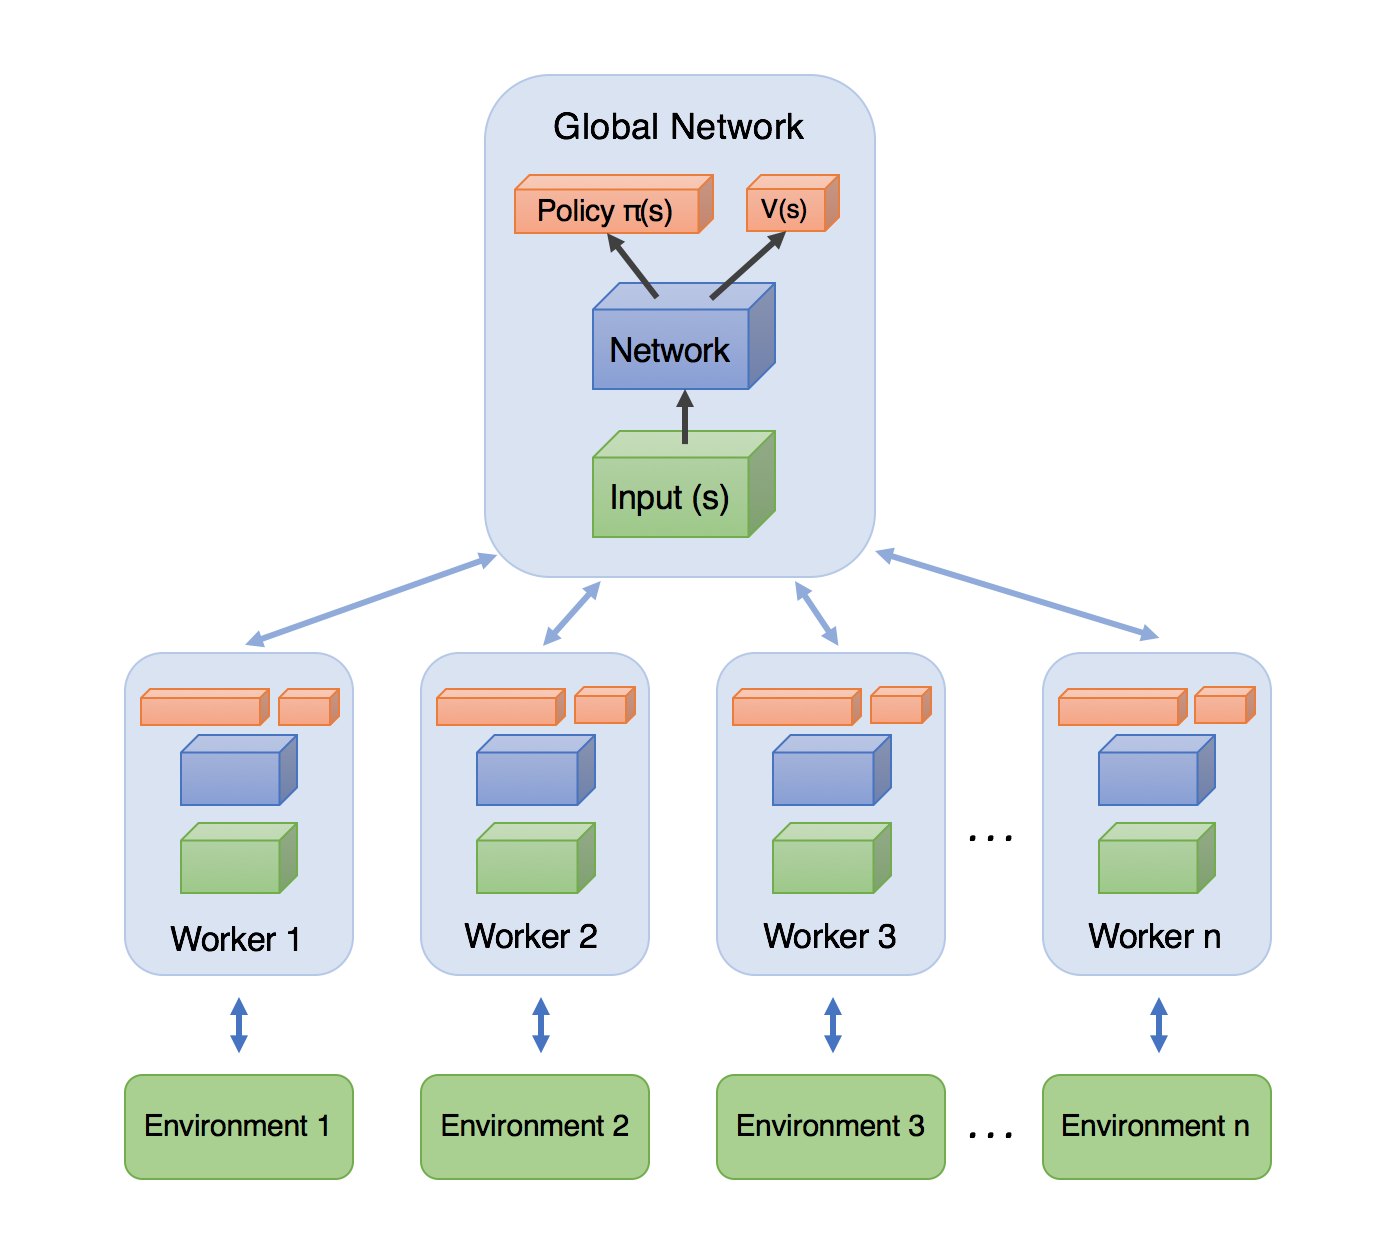

In [ ]:
Image('1.png',width=600)

## 3.3 어떻게 A3C에서는 여러 액터-러너actor-learner를 각 env에서 play하게 하는가?  
  
 > 멀티 스레딩의 사용 때문이다.

## 3.4 멀티 스레딩

- 스레딩Treading이란?

> 스레드(thread)는 어떠한 프로그램 내에서, 특히 프로세스 내에서 실행되는 흐름의 단위를 말한다. 일반적으로 한 프로그램은 하나의 스레드를 가지고 있지만, 프로그램 환경에 따라 둘 이상의 스레드를 동시에 실행할 수 있다. 이러한 실행 방식을 멀티스레드(multithread)라고 한다. (wiki)

- 멀티 스레딩이란? 

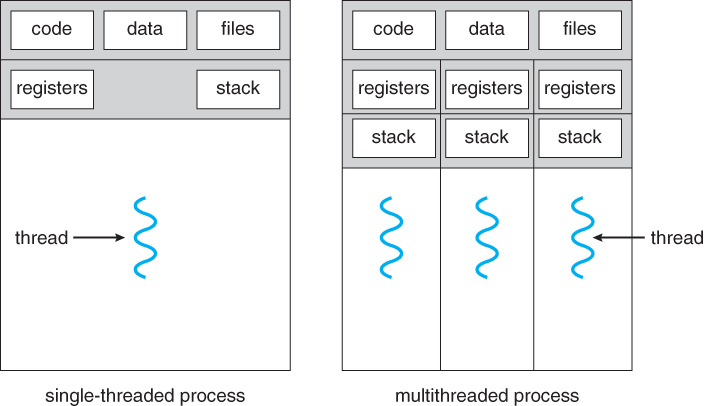

In [ ]:
Image('t1.jpg',width=600)

#### 3.4.1 Benefits

- **Responsiveness** - One thread may provide rapid response while other threads are blocked or slowed down doing intensive calculations.    

- **Resource** **sharing** - By default threads share common code, data, and other resources, which allows multiple tasks to be performed simultaneously in a single address space.  

- **Economy** - Creating and managing threads ( and context switches between them ) is much faster than performing the same tasks for processes.  

- **Scalability**, i.e. *Utilization of multiprocessor architectures* - A single threaded process can only run on one CPU, no matter how many may be available, whereas the execution of a multi-threaded application may be split amongst available processors. 


#### 3.4.2 Applications

In [3]:
import itertools
import threading
import time as t
import multiprocessing
import numpy as np

class Worker:

    def __init__(self, id_, global_counter):

        self.id = id_
        self.global_counter = global_counter # 글로벌 카운터
        self.local_counter = itertools.count() # 로컬 카운터

    def run(self):

        while True:

            time.sleep(np.random.rand()*2)
            global_step = next(self.global_counter)
            local_step = next(self.local_counter)

            print("Worker({}):{}".format(self.id,local_step))
            if global_step >= 20:
                break
"""
대역 카운터와 로컬 카운터가 서로 상호 업데이트 하는 동안에,
대역 카운터가 20 이상이 되면 중지
"""
global_counter = itertools.count()
NUM_WORKERS = multiprocessing.cpu_count()


일꾼 만들기

In [4]:
# 일꾼 만들기

workers=[]
for worker_id in range(NUM_WORKERS):
    worker = Worker(worker_id, global_counter)
    workers.append(worker)

쓰레드 시작

In [ ]:
worker_threads=[]
for worker in workers:
    worker_fn = lambda: worker.run()
    t = threading.Thread(target=worker_fn)
    t.start()
    worker_threads.append(t)

쓰레드 조인

In [ ]:
for t in worker_threads:
    t.join()

print("done!")

Worker(1):0
Worker(0):1
Worker(0):2
Worker(0):3
Worker(1):1
Worker(0):4
Worker(0):5
Worker(0):6
Worker(1):2
Worker(1):3
Worker(0):7
Worker(0):8
Worker(1):4
Worker(0):9
Worker(0):10
Worker(1):5
Worker(1):6
Worker(1):7
Worker(0):11
Worker(0):12
Worker(1):8
done!


## 3.5 Algorithms

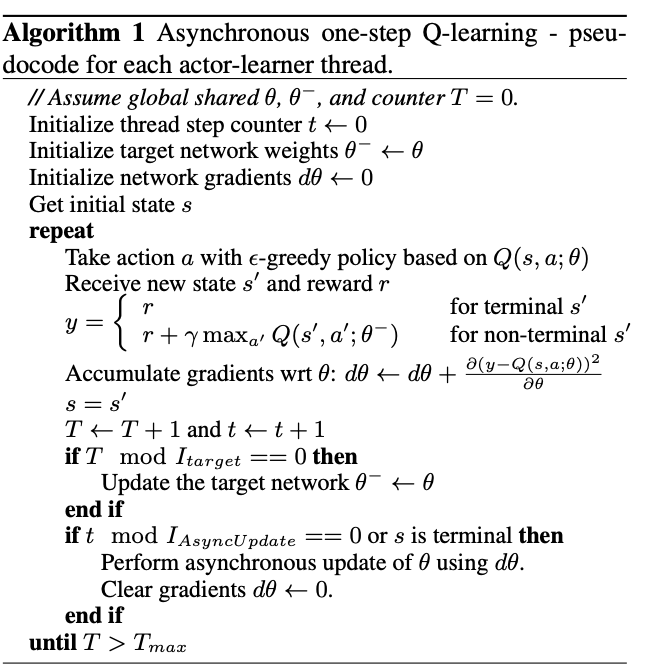

In [ ]:
Image('t2.png')

## 3.6 code (in our textbook)

In [5]:
import os
import gym
import time
import threading
import random
import numpy as np
import tensorflow as tf
import keras

from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.compat.v1.train import AdamOptimizer
from tensorflow.keras.layers import Conv2D, Flatten, Dense

멀티쓰레딩을 위한 글로벌 변수 설정 (에피소드, 평균 스코어, 최대 스코어)

In [6]:
global episode, score_avg, score_max
episode, score_avg, score_max = 0, 0, 0
num_episode = 8000000

##### 3.6.1 Actor-Critic
  
> 이것은 아래 그림과 같이 (1) 하나의 글로벌 신경망에 대한 클래스, (2) 하나의 액터러너에 대한 클래스를 갖는다.

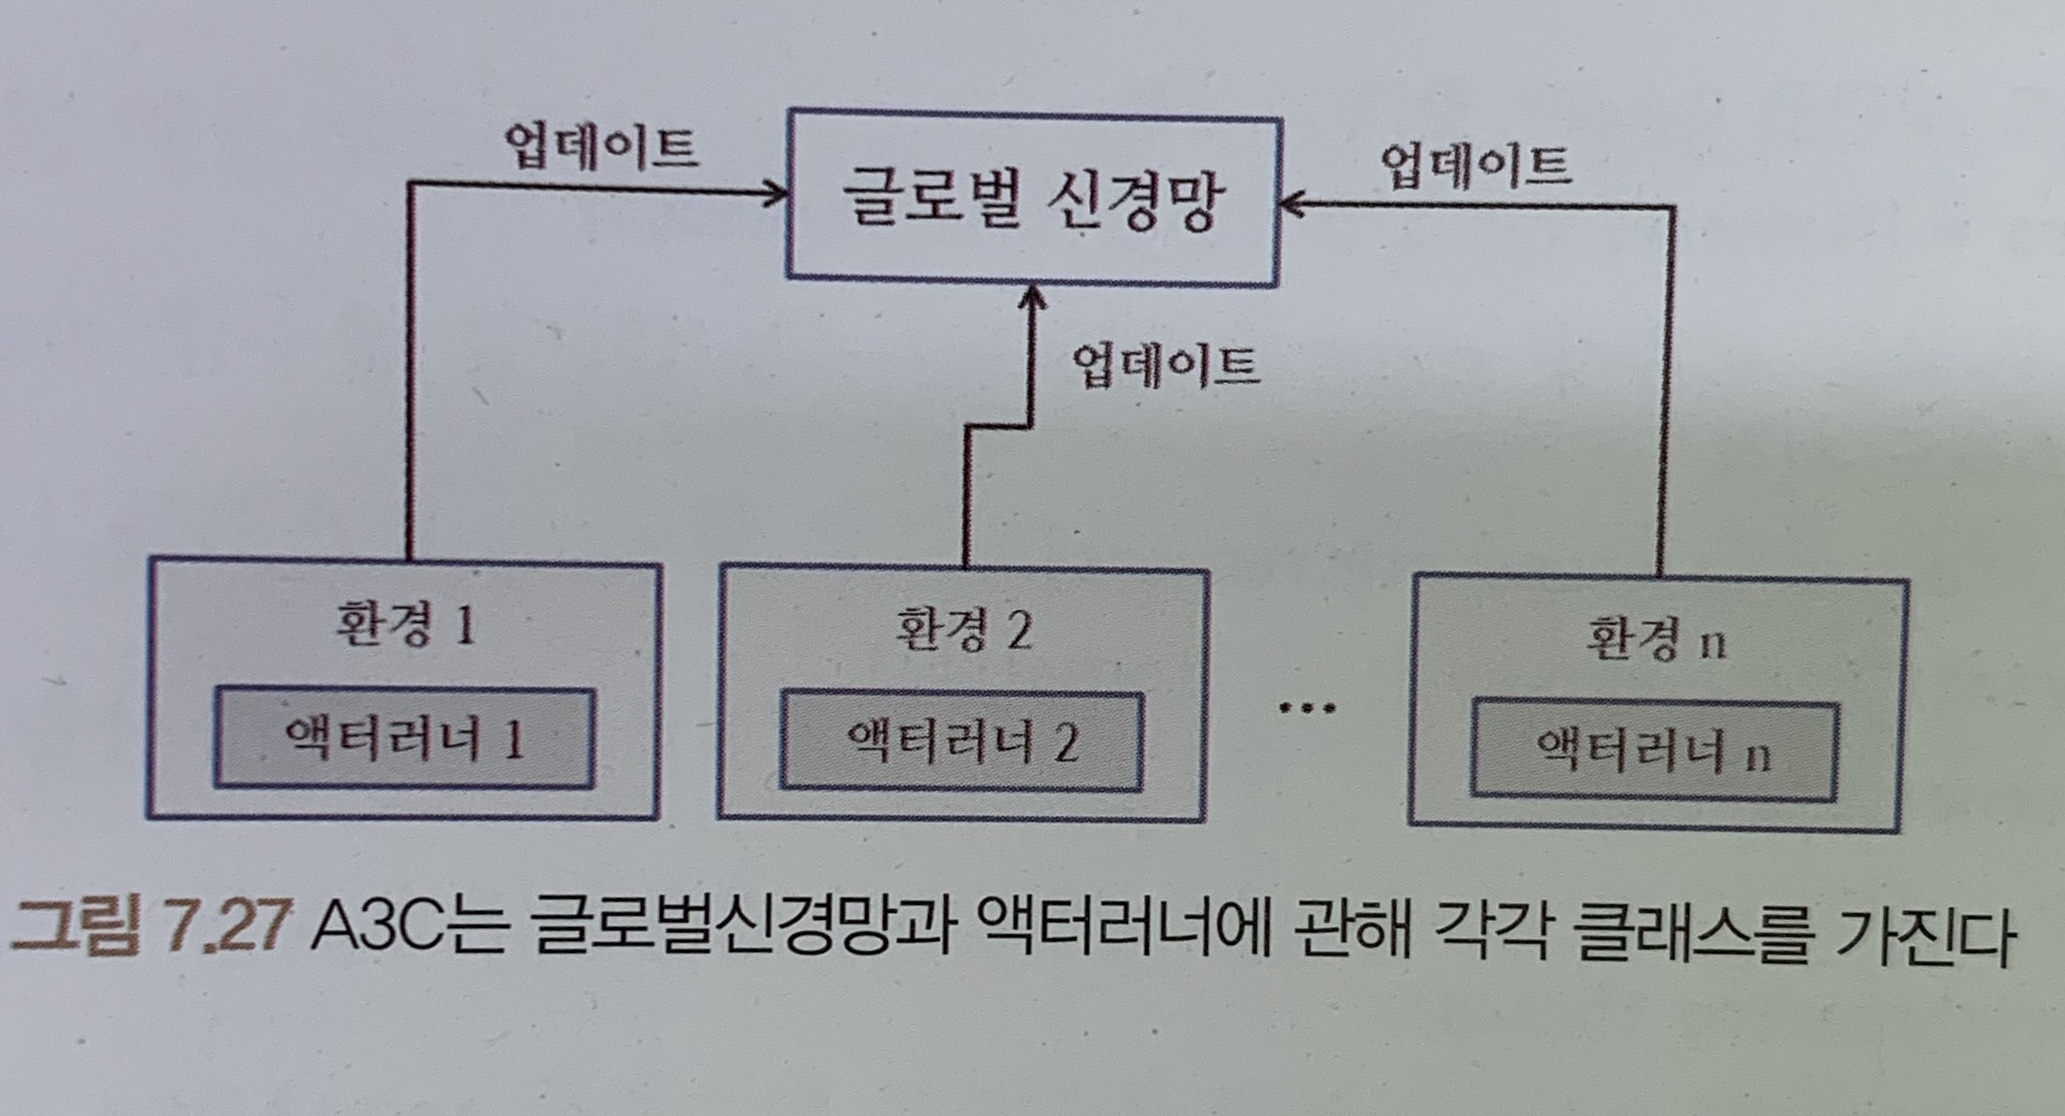

In [ ]:
Image('t3.JPG',width=600)

In [7]:
# ActorCritic 인공신경망
class ActorCritic(tf.keras.Model):
    def __init__(self, action_size, state_size):
        super(ActorCritic, self).__init__()

        self.conv1 = Conv2D(32, (8, 8), strides=(4, 4), activation='selu',
                            input_shape=state_size)
        self.bn = keras.layers.BatchNormalization() # 학습 효율화 및 안정성을 위해 배치 정규화 추가
        self.conv2 = Conv2D(64, (4, 4), strides=(2, 2), activation='selu')
        self.bn = keras.layers.BatchNormalization()
        self.conv3 = Conv2D(64, (3, 3), strides=(1, 1), activation='selu')
        self.bn = keras.layers.BatchNormalization()
        self.flatten = Flatten()
        self.shared_fc = Dense(512, activation='selu')

        self.policy = Dense(action_size, activation='linear') 
        self.value = Dense(1, activation='linear') 

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.shared_fc(x)

        policy = self.policy(x)
        value = self.value(x)
        return policy, value # 정책,가치 신경망 공유


##### 3.6.2 A3CAgent

In [8]:
# 브레이크아웃에서의 A3CAgent 클래스 (글로벌신경망)
class A3CAgent():

    def __init__(self, action_size, env_name):
        self.env_name = env_name
        # 상태와 행동의 크기 정의
        self.state_size = (84, 84, 4)
        self.action_size = action_size
        # A3C 하이퍼파라미터
        self.discount_factor = 0.99
        self.no_op_steps = 30
        self.lr = 1e-4

        ##################  16 개의 쓰레드를 사용하여 멀티 쓰레드 이용  ################## 
        self.threads = 16

        ##################   글로벌 인공신경망 생성   ##################
        #                                                        #
        #                 글로벌 신경망은 A3Cagent에서 선언            #
        #                                                        #
        #     로컬 신경망에서 학습한 gradient --> 글로벌신경망 업데이트     #
        ##########################################################   

        self.global_model = ActorCritic(self.action_size, self.state_size)
        self.global_model.build(tf.TensorShape((None, *self.state_size))) # 글로벌 인공신경망의 가중치 초기화

        ################## 인공신경망 업데이트하는 옵티마이저 함수 생성 ##################
        self.optimizer = AdamOptimizer(self.lr, use_locking=True)

        
        self.writer = tf.summary.create_file_writer('summary/breakout_a3c') # 텐서보드 설정
        # 학습된 글로벌신경망 모델을 저장할 경로 설정
        self.model_path = os.path.join(os.getcwd(), 'save_model', 'model')

    ########################  쓰레드를 만들어 학습을 하는 함수  ########################

    def train(self):
        # 쓰레드 수 만큼 Runner 클래스 생성
        runners = [Runner(self.action_size, self.state_size,
                          self.global_model, self.optimizer,
                          self.discount_factor, self.env_name,
                          self.writer) for i in range(self.threads)] 

        # 러너 시작 --> worker로서의 각 쓰레드 일 시작
        for i, runner in enumerate(runners):
            print("Start worker #{:d}".format(i+1))
            runner.start()

        # 10분 (600초)에 한 번씩 모델을 저장
        while True:
            self.global_model.save_weights(self.model_path, save_format="tf")
            time.sleep(60 * 10)

##### 3.6.3 Runner 클래스  
  > 멀티 쓰레드 수행

In [9]:
# 액터러너 클래스 (쓰레드)
class Runner(threading.Thread):
    global_episode = 0

    def __init__(self, action_size, state_size, global_model,
                 optimizer, discount_factor, env_name, writer):
        threading.Thread.__init__(self)

        # A3CAgent 클래스에서 넘겨준 하이준 파라미터 설정
        self.action_size = action_size
        self.state_size = state_size
        self.global_model = global_model
        self.optimizer = optimizer
        self.discount_factor = discount_factor

        self.states, self.actions, self.rewards = [], [], []

        # 환경, 로컬신경망, 텐서보드 생성
        self.local_model = ActorCritic(action_size, state_size)
        self.env = gym.make(env_name)
        self.writer = writer

        # 학습 정보를 기록할 변수
        self.avg_p_max = 0
        self.avg_loss = 0
        # k-타임스텝 값 설정
        self.t_max = 20
        self.t = 0
        # 불필요한 행동을 줄여주기 위한 dictionary
        self.action_dict = {0:1, 1:2, 2:3, 3:3}

    # 텐서보드에 학습 정보를 기록
    def draw_tensorboard(self, score, step, e):
        avg_p_max = self.avg_p_max / float(step)
        with self.writer.as_default():
            tf.summary.scalar('Total Reward/Episode', score, step=e)
            tf.summary.scalar('Average Max Prob/Episode', avg_p_max, step=e)
            tf.summary.scalar('Duration/Episode', step, step=e)

    # 정책신경망의 출력을 받아 확률적으로 행동을 선택
    def get_action(self, history):
        history = np.float32(history / 255.)
        policy = self.local_model(history)[0][0]
        policy = tf.nn.softmax(policy)
        action_index = np.random.choice(self.action_size, 1, p=policy.numpy())[0]
        return action_index, policy

    # 샘플을 저장
    def append_sample(self, history, action, reward):
        self.states.append(history)
        act = np.zeros(self.action_size)
        act[action] = 1
        self.actions.append(act)
        self.rewards.append(reward)

    # k-타임스텝의 prediction 계산
    def discounted_prediction(self, rewards, done):
        discounted_prediction = np.zeros_like(rewards)
        running_add = 0

        if not done:
            # value function
            last_state = np.float32(self.states[-1] / 255.)
            running_add = self.local_model(last_state)[-1][0].numpy()

        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_prediction[t] = running_add
        return discounted_prediction

    # 저장된 샘플들로 A3C의 오류함수를 계산
    def compute_loss(self, done):

        discounted_prediction = self.discounted_prediction(self.rewards, done)
        discounted_prediction = tf.convert_to_tensor(discounted_prediction[:, None],
                                                     dtype=tf.float32)

        states = np.zeros((len(self.states), 84, 84, 4))

        for i in range(len(self.states)):
            states[i] = self.states[i]
        states = np.float32(states / 255.)

        policy, values = self.local_model(states)

        # 가치 신경망 업데이트
        advantages = discounted_prediction - values
        critic_loss = 0.5 * tf.reduce_sum(tf.square(advantages))

        # 정책 신경망 업데이트
        action = tf.convert_to_tensor(self.actions, dtype=tf.float32)
        policy_prob = tf.nn.softmax(policy)
        action_prob = tf.reduce_sum(action * policy_prob, axis=1, keepdims=True)
        cross_entropy = - tf.math.log(action_prob + 1e-10)
        actor_loss = tf.reduce_sum(cross_entropy * tf.stop_gradient(advantages))

        entropy = tf.reduce_sum(policy_prob * tf.math.log(policy_prob + 1e-10), axis=1)
        entropy = tf.reduce_sum(entropy)
        actor_loss += 0.01 * entropy

        total_loss = 0.5 * critic_loss + actor_loss

        return total_loss

    # 로컬신경망을 통해 그레이디언트를 계산하고, 글로벌 신경망을 계산된 그레이디언트로 업데이트
    def train_model(self, done):

        global_params = self.global_model.trainable_variables
        local_params = self.local_model.trainable_variables

        with tf.GradientTape() as tape:
            total_loss = self.compute_loss(done)

        # 로컬신경망의 그레이디언트 계산
        grads = tape.gradient(total_loss, local_params)
        # 안정적인 학습을 위한 그레이디언트 클리핑
        grads, _ = tf.clip_by_global_norm(grads, 40.0)
        # 로컬신경망의 오류함수를 줄이는 방향으로 글로벌신경망을 업데이트
        self.optimizer.apply_gradients(zip(grads, global_params))
        # 로컬신경망의 가중치를 글로벌신경망의 가중치로 업데이트
        self.local_model.set_weights(self.global_model.get_weights())
        # 업데이트 후 저장된 샘플 초기화
        self.states, self.actions, self.rewards = [], [], []


################################################################################
#                                                                              #
#                   환경과 상호작용하는 부분이 모두 아래의 run 함수에 있다                 #
#                                                                              #
################################################################################


    def run(self):
        # 액터러너끼리 공유해야하는 글로벌 변수
        global episode, score_avg, score_max

        step = 0
        while episode < num_episode:
            done = False
            dead = False

            score, start_life = 0, 5 # 0점부터 시작 5 개의 목숨을 가진 게임 주인공.
            observe = self.env.reset()

            # 랜덤으로 뽑힌 값 만큼의 프레임동안 움직이지 않음
            for _ in range(random.randint(1, 30)):
                observe, _, _, _ = self.env.step(1)

            # 프레임(관측치)을 전처리 한 후 4개의 상태를 쌓아서 입력값으로 사용.
            state = pre_processing(observe)
            history = np.stack([state, state, state, state], axis=2)
            history = np.reshape([history], (1, 84, 84, 4))

            while not done:
                step += 1
                self.t += 1

                # 정책 확률에 따라 행동을 선택
                action, policy = self.get_action(history)
                # 1: 정지, 2: 왼쪽, 3: 오른쪽
                real_action = self.action_dict[action]
                # 죽었을 때 시작하기 위해 발사 행동을 함
                if dead:
                    action, real_action, dead = 0, 1, False

                # 선택한 행동으로 환경에서 한 타임스텝 진행
                observe, reward, done, info = self.env.step(real_action)

                # 각 타임스텝마다 상태 전처리
                next_state = pre_processing(observe)
                next_state = np.reshape([next_state], (1, 84, 84, 1))
                next_history = np.append(next_state, history[:, :, :, :3], axis=3)

                # 정책확률의 최대값
                self.avg_p_max += np.amax(policy.numpy())

                if start_life > info['ale.lives']:
                    dead = True
                    start_life = info['ale.lives']

                score += reward
                reward = np.clip(reward, -1., 1.)

                # 샘플을 저장
                self.append_sample(history, action, reward)

                if dead:
                    history = np.stack((next_state, next_state,
                                        next_state, next_state), axis=2)
                    history = np.reshape([history], (1, 84, 84, 4))
                else:
                    history = next_history

                # 에피소드가 끝나거나 최대 타임스텝 수에 도달하면 학습을 진행
                if self.t >= self.t_max or done:
                    self.train_model(done)
                    self.t = 0

                if done:
                    # 각 에피소드 당 학습 정보를 기록
                    episode += 1
                    score_max = score if score > score_max else score_max
                    score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score

                    log = "episode: {:5d} | score : {:4.1f} | ".format(episode, score)
                    log += "score max : {:4.1f} | ".format(score_max)
                    log += "score avg : {:.3f}".format(score_avg)
                    print(log)

                    self.draw_tensorboard(score, step, episode)

                    self.avg_p_max = 0
                    step = 0


# 학습속도를 높이기 위해 흑백화면으로 전처리
def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe


if __name__ == "__main__":
    global_agent = A3CAgent(action_size=3, env_name="BreakoutDeterministic-v4")
    global_agent.train()

Start worker #0
Start worker #1
Start worker #2
Start worker #3
Start worker #4
Start worker #5
Start worker #6
Start worker #7
Start worker #8
Start worker #9
Start worker #10
Start worker #11
Start worker #12
Start worker #13
Start worker #14
Start worker #15
episode:     1 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     2 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     3 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     4 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     5 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     6 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     7 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     8 | score :  1.0 | score max :  1.0 | score avg : 1.000
episode:     9 | score :  2.0 | score max :  2.0 | score avg : 1.100
episode:    10 | score :  2.0 | score max :  2.0 | score avg : 1.190
episode:    11 | score :  1.0 | score max :  2.0

KeyboardInterrupt: ignored

# References  
[1] "파이썬과 케라스로 배우는 강화학습"  

[2]https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php  
[3] https://www.youtube.com/watch?v=iCV3vOl8IMk.  

[4]https://www.cs.uic.edu/~jbell/CourseNotes/OperatingSystems/4_Threads.html [Multi-Threading]  
[5] The original paper ['Asynchronous Methods for Deep Reinforcement Learning'](https://arxiv.org/abs/1602.01783)
